# Classification: II

*S. R. Taylor (2021)*

This lecture and notebook are based on the "Classification" and "Classification2" lectures of of G. Richards' "Astrostatistics" class at Drexel University (PHYS 440/540, https://github.com/gtrichards/PHYS_440_540), which in turn are based on materials from Andy Connolly, and Ivezic et al. Chapter 9, Andy Connolly's [blog](http://connolly.github.io/introAstroML/blog/regression.html), and Aurelien Geron's [book](https://github.com/ageron/handson-ml2). 

##### Reading:

- [Textbook](http://press.princeton.edu/titles/10159.html) Chapter 9.

---

## Contents
* [Discriminative classification](#one)
* [Logistic regression](#two)
* [Support vector machines (SVM)](#three)
* [Decision trees](#four)
* [Ensemble learning](#five)
* [Alright, brilliant, but which one should I use?](#six)
    
---

***Exercises required for class participation are in <font color='red'>red</font>.***

---

## Discriminative Classification <a class="anchor" id="one"></a>

Last time we talked about how to perform classification by mapping the full pdf of the data's feature space, and probabilistically ranking the population that a new sample would belong to. This was **generative classification**, because we we estimating a generative model of the data. 

This time we will concentrate on methods that seek only to determine the **decision boundary** in feature space, so called [**discriminative classification**](https://en.wikipedia.org/wiki/Discriminative_model) methods.

As before, let's say that you have 2 blobs of data as shown below. In many cases, you might say "just draw a line between those two blobs that are well separated". So let's do exactly that in the example below. There are clearly lots of different lines that you could draw that would work.  So, how do you do this *optimally*?  And what if the blobs are not perfectly well separated?

<!-- ![Ivezic, Figure 9.9](figures/svm_lines.png) -->

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

(-1.0, 3.5)

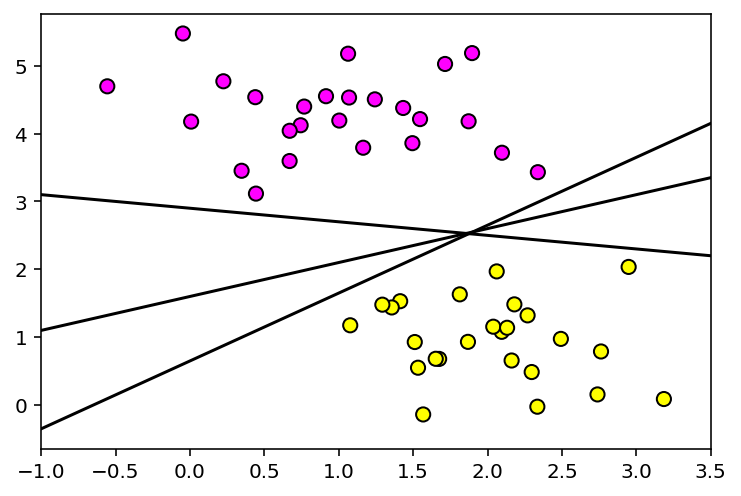

In [2]:
# Source: https://github.com/jakevdp/ESAC-stats-2014/blob/master/notebooks/04.1-Classification-SVMs.ipynb
import numpy as np
from scipy import stats
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring' ,edgecolor='k');

Xgrid = np.linspace(-1, 3.5)
for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(Xgrid, m * Xgrid + b, '-k')
    
plt.xlim(-1, 3.5)

## Logistic Regression <a class="anchor" id="two"></a>

In [Logistic Regression](https://www.wikiwand.com/en/Logistic_regression) we use a model that is almost identical to how we did LDA. For two-class classification with $y=\{0,1\}$ we use the [logistic function](https://www.wikiwand.com/en/Logistic_function) to write

$$ p(y=1|x) = \frac{\exp\left[\sum_j\theta_jx^j \right]}{1 + \exp\left[\sum_j\theta_jx^j \right]}, $$

where the sum is over data features, and for the $i$-th sample we define

$$ \ln\left(\frac{p_i}{1-p_i} \right) = \sum_j\theta_jx^j_i. $$

- In **LDA** we modeled the pdfs of each class as having identical multivariate Gaussian covariance functions in feature-space. We used the model: 
$$ 
\begin{align}
        \ln\left( \frac{p(y=1|x)}{p(y=0|x)} \right) &= -\frac{1}{2}(\mu_0+\mu_1)^T\Sigma^{-1}(\mu_0-\mu_1) + \ln\frac{p(y=0)}{p(y=1)} + x^T\Sigma^{-1}(\mu_1-\mu_0) \\
        &= \alpha_0 + \alpha^T x,
\end{align}
$$
which is clearly linear in the data.


- In **Logistic Regression**, the model is by assumption

$$ \ln\left( \frac{p(y=1|x)}{p(y=0|x)} \right) = \beta_0 + \beta^T x $$


***The only difference between LDA and Logstic Regression is how the regression coefficients are estimated. In LDA they are chosen to minimize density estimation error, whereas in Logistic Regression they are chosen to minimize classifcation error.***

Let's see how Logistic Regression performs on our classification of non-variable stars versus RR Lyrae.

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


completeness [0.98540146 1.         1.         1.        ]
contamination [0.88588335 0.84180139 0.84088269 0.84014002]


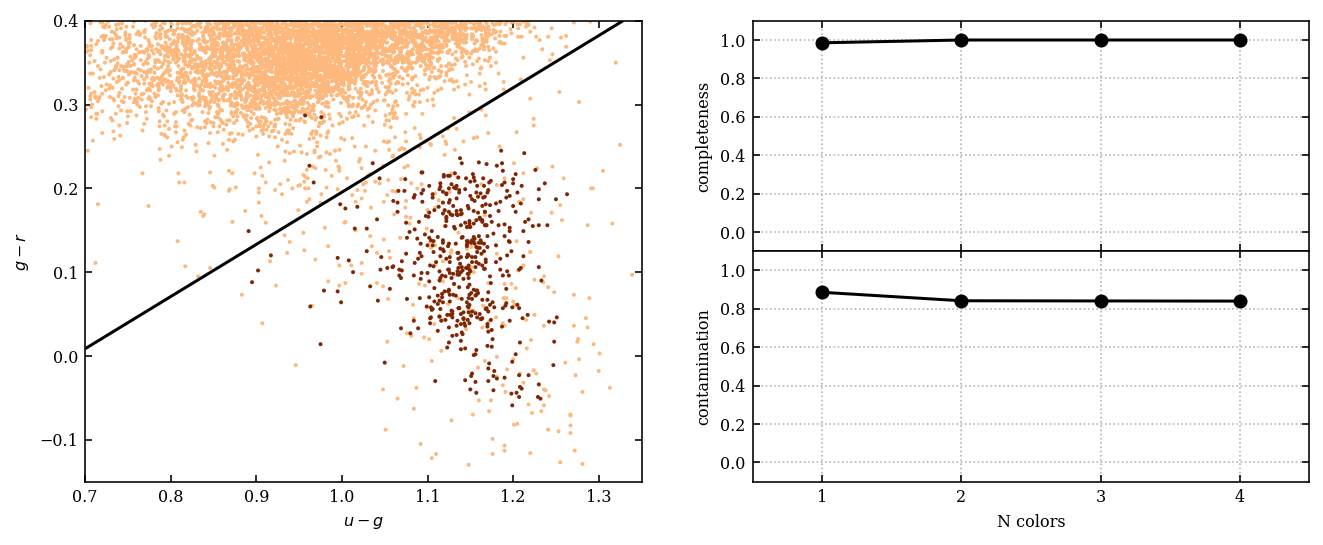

In [3]:
# # Ivezic v2, Figure 9.8, edits by SRT
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
from matplotlib import colors

from sklearn.linear_model import LogisticRegression
from astroML.datasets import fetch_rrlyrae_combined
from astroML.utils import split_samples
from astroML.utils import completeness_contamination

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

#----------------------------------------------------------------------
# get data and split into training & testing sets
Xnew, ynew = fetch_rrlyrae_combined()
Xnew = Xnew[:, [1, 0, 2, 3]]  # rearrange columns for better 1-color results
(X_train, X_test), (y_train, y_test) = split_samples(Xnew, ynew, [0.75, 0.25],
                                                     random_state=0)

N_tot = len(ynew)
N_st = np.sum(ynew == 0)
N_rr = N_tot - N_st
N_train = len(y_train)
N_test = len(y_test)
N_plot = 5000 + N_rr

#----------------------------------------------------------------------
# perform Classification
classifiers = []
predictions = []
Ncolors = np.arange(1, Xnew.shape[1] + 1)

for nc in Ncolors:
    clf = LogisticRegression(class_weight='balanced')
    clf.fit(X_train[:, :nc], y_train)
    y_pred = clf.predict(X_test[:, :nc])

    classifiers.append(clf)
    predictions.append(y_pred)

completeness, contamination = completeness_contamination(predictions, y_test)

print("completeness", completeness)
print("contamination", contamination)

#------------------------------------------------------------
# Compute the decision boundary
clf = classifiers[1]
xlim = (0.7, 1.35)
ylim = (-0.15, 0.4)

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 71),
                     np.linspace(ylim[0], ylim[1], 81))

Z = clf.predict_proba(np.c_[yy.ravel(), xx.ravel()])[:, 1]
Z = Z.reshape(xx.shape)

#----------------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(10, 4))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0,
                    left=0.1, right=0.95, wspace=0.2)

# left plot: data and decision boundary
ax = fig.add_subplot(121)
im = ax.scatter(Xnew[-N_plot:, 1], Xnew[-N_plot:, 0], c=ynew[-N_plot:],
                s=4, lw=0, cmap=plt.cm.Oranges, zorder=2)
im.set_clim(-0.5, 1)

ax.contour(xx, yy, Z, [0.5], colors='k')

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel('$u-g$')
ax.set_ylabel('$g-r$')

# plot completeness vs Ncolors
ax = fig.add_subplot(222)

ax.plot(Ncolors, completeness, 'o-k', ms=6)

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.NullFormatter())

ax.set_ylabel('completeness')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

# plot contamination vs Ncolors
ax = fig.add_subplot(224)
ax.plot(Ncolors, contamination, 'o-k', ms=6)

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))
ax.set_xlabel('N colors')
ax.set_ylabel('contamination')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

plt.show()

## Support Vector Machines <a class="anchor" id="three"></a>

**[Support Vector Machines (SVM)](https://en.wikipedia.org/wiki/Support_vector_machine)** define a hyperplane (a plane in $N-1$ dimensions) that maximizes the distance of the closest point from each class. This distance is the "margin". It is the width of the "cylinder" or "street" that you can put between the closest points that just barely touches the points in each class. The points that touch the margin (or that are on the wrong side) are called **support vectors**.  Obvious, right? And not as obscure as the name may imply. 

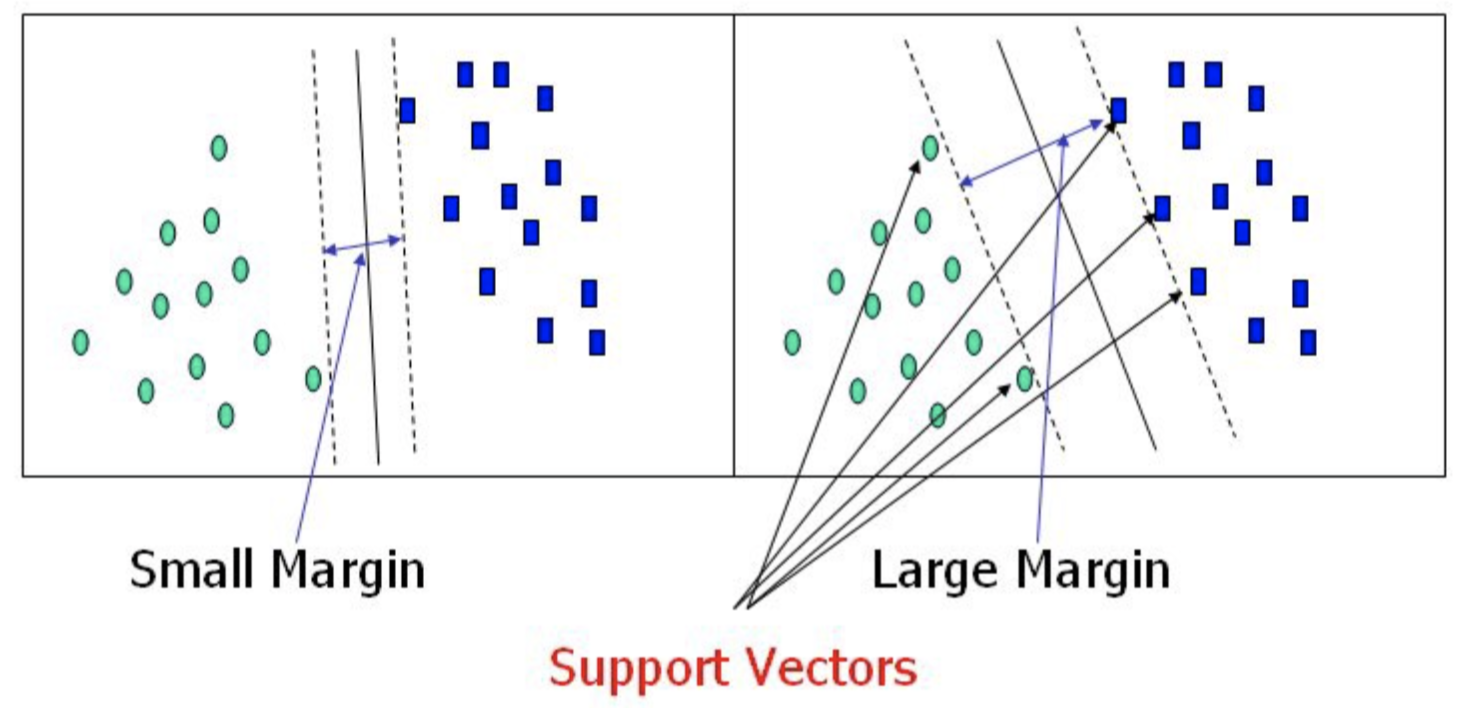

Image credit: [here](https://towardsdatascience.com/support-vector-machine-introduction-to-machine-learning-algorithms-934a444fca47)

There are lots of potential decision boundaries, but we want the one that maximize the distance of the support vectors from the decision hyperplane.

(-1.0, 3.5)

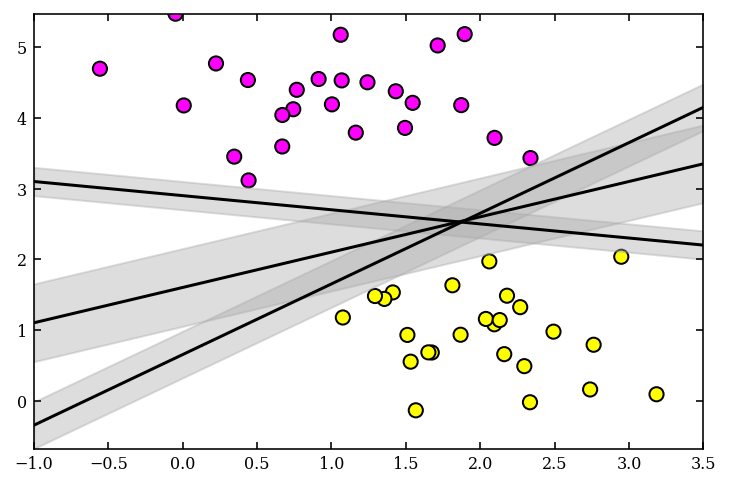

In [4]:
Xgrid = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], 
            c=y, s=50, cmap='spring', 
            edgecolor='k')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * Xgrid+ b
    plt.plot(Xgrid, yfit, '-k')
    plt.fill_between(Xgrid, yfit - d, yfit + d, 
                     edgecolor='None', 
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5)

Here's the math for determining the decision boundary. To make life easier, we'll assume that the classes are separable by a straight line and that the decision boundary is at 0, with the two edges at $-1$ and $1$, and define $y \in \{-1,1\}$.

**The hyperplane that maximizes the margin** is given by finding

$$ 
\begin{equation}
\max_{\beta_0,\beta}(m) \;\;\;
  \mbox{subject to} \;\;\; \frac{1}{||\beta||} y_i ( \beta_0 + \beta^T x_i )
  \geq m \,\,\, \forall \, i.
\end{equation}
$$

where $||\beta|| = \sqrt{\sum \beta^2}$. 

The constraints can be written as $y_i ( \beta_0 + \beta^T x_i ) \geq m ||\beta|| $. Thus the optimization problem is equivalent to minimizing

$$
\begin{equation}
\frac{1}{2} ||\beta|| \;\;\; \mbox{subject to} \;\;\; y_i
  ( \beta_0 + \beta^T x_i ) \geq 1 \,\,\, \forall \, i.
\end{equation}
$$

We'll skip over the mathematical details, but you can read about them in detail in Ivezic $\S$ 9.6 or in Karen Leighly's [classification lecture notes](http://seminar.ouml.org/lectures/classification/).

For realistic data sets where the decision boundary is not obvious, we relax the assumption that the classes are linearly separable. This changes the minimization condition and puts bounds on the number of misclassifications (which we would obviously like to minimize).

Treating Scikit-Learn's agorithm as a black box, let's fit a Support Vector Machine Classifier to these points.

The Scikit-Learn implementation of SVM classification is [`SVC`](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) which looks like:

In [10]:
from sklearn.svm import SVC

svm = SVC(kernel='linear', C=1.0) # will explain 'C' below
svm.fit(X,y)

SVC(kernel='linear')

In order to better visualize what SVM is doing, let's create a convenience function that will plot the decision boundaries:

In [6]:
def plot_svc_decision_function(clf, ax=None):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    u = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    v = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    yy, xx = np.meshgrid(v, u)

    P = np.zeros_like(xx)
    for i, ui in enumerate(u):
        for j, vj in enumerate(v):
            Xgrid = np.array([ui, vj])
            P[i, j] = clf.decision_function(Xgrid.reshape(1,-1))
    return ax.contour(xx, yy, P, colors='k',
                      levels=[-1, 0, 1], alpha=0.5,
                      linestyles=['--', '-', '--'])

Now let's plot the decision boundary and the support vectors, which are stored in the `support_vectors_` attribute of the classifier.  <font color='red'>Try it.</font>

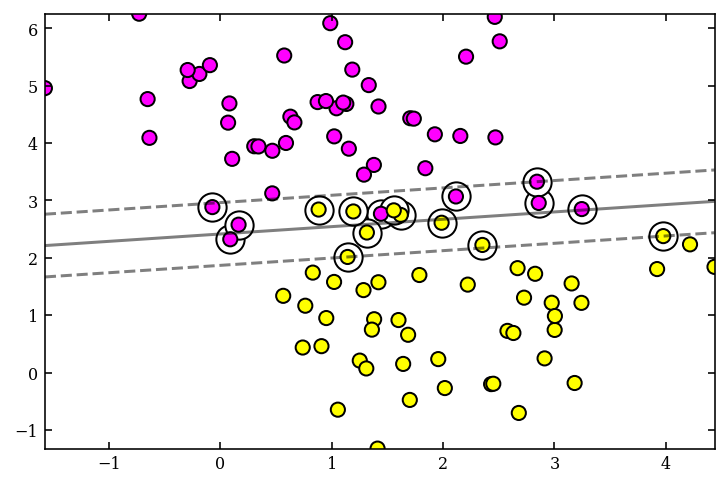

In [11]:
plt.scatter(svm.support_vectors_[:, 0], svm.support_vectors_[:, 1], 
            s=200, edgecolor='k', facecolor='w'); #Add support vectors
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, 
            cmap='spring', edgecolor='k')
plot_svc_decision_function(svm)

Let's look at what happens for data that have some overlap between the classes. <font color='red'>Execute the cell below to create overlapping data, then go back to the previous cell to plot the decision boundary and support vectors of the best-fit SVM classifier.</font>

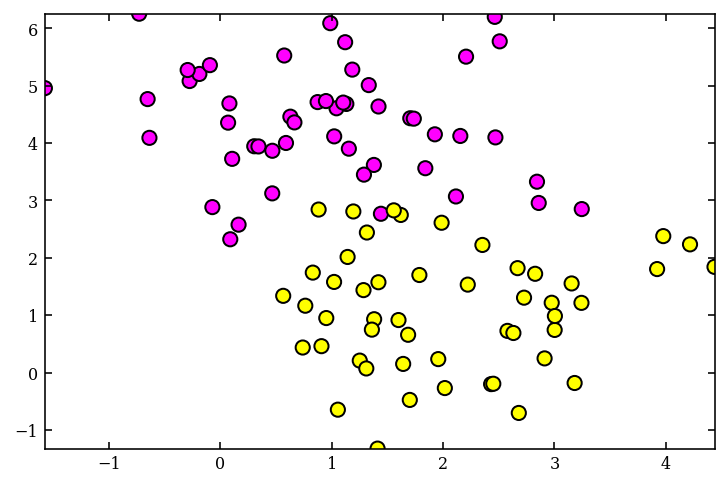

In [8]:
# Source: https://github.com/jakevdp/ESAC-stats-2014/blob/master/notebooks/04.1-Classification-SVMs.ipynb
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, 
            cmap='spring' ,edgecolor='k');

Our example above included a parameter, $C$, which I didn't exaplain. According to the [SVC documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html?highlight=svc#sklearn.svm.SVC), 

> $C$ is a "*regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive. The penalty is a squared L2 penalty.*"

Thus this is the **inverse** of the $\alpha$ regularization parameter we saw in our regression lectures. <font color='red'>Let's see what happens when we change it.  Fit these data with `C=100` (less regularization) and `C=0.01` (more regularization).</font>

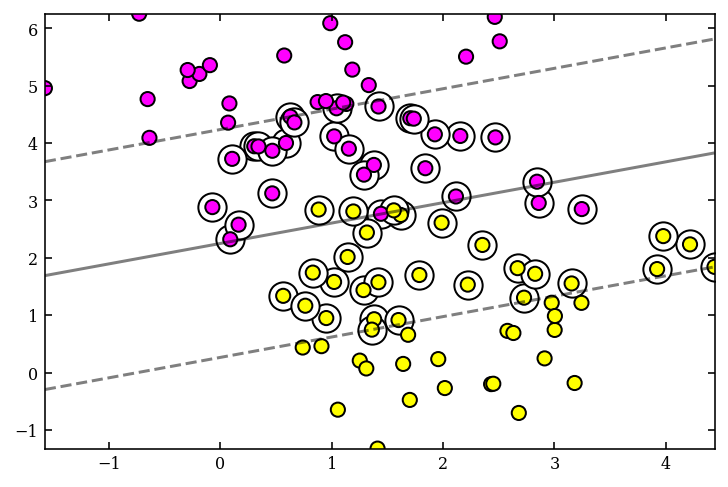

In [13]:
svm = SVC(kernel='linear', C=0.01)
svm.fit(X,y)

plt.scatter(svm.support_vectors_[:, 0], 
            svm.support_vectors_[:, 1], 
            s=200, edgecolor='k', facecolor='w');
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, 
            cmap='spring', edgecolor='k')
plot_svc_decision_function(svm)

- We see that **$C$ controls the number of "margin violations"** that are allowed, and the width of the "street" that runs between the data (i.e., the number of support vectors).

- Note that **SVM *only* depends on the support vectors**. You can get rid of the rest of the data. Smaller $C$ causes there to be more support vectors, while larger $C$ gives fewer.

Try SVM classification on our star sample:

@pickle_results: computing results and saving to 'SVM_rrlyrae.pkl'
completeness [0.99270073 1.         1.         1.        ]
contamination [0.90014684 0.85347594 0.85347594 0.85471898]


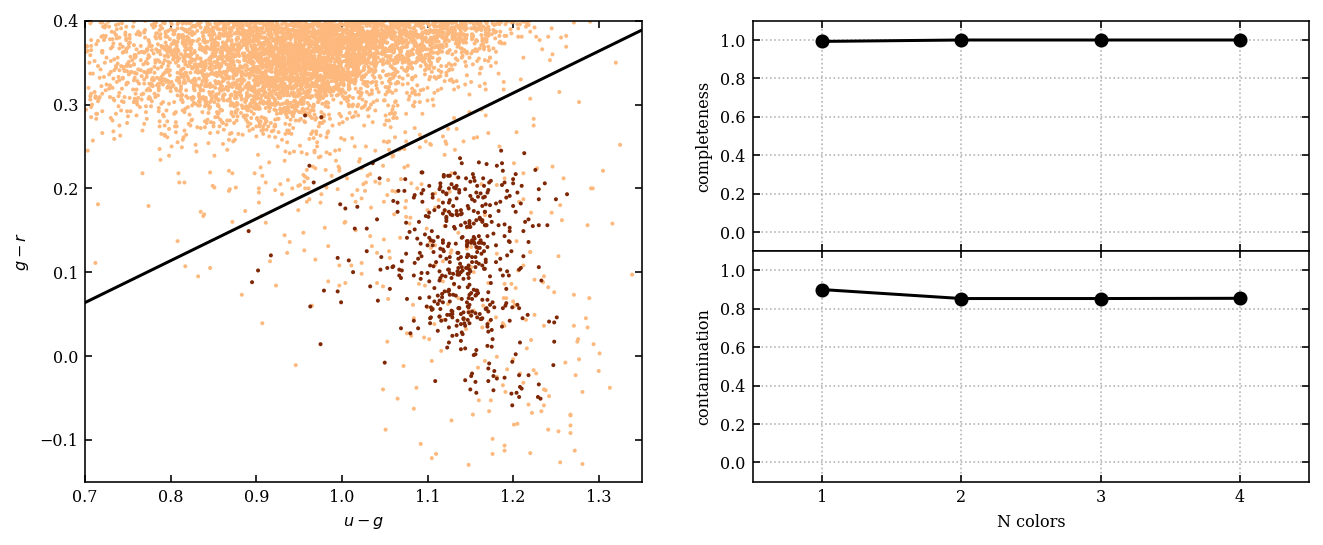

In [14]:
# Ivezic v2, Figure 9.10, edits by GTR and SRT
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
from sklearn.svm import SVC
from astroML.utils.decorators import pickle_results
from astroML.datasets import fetch_rrlyrae_combined
from astroML.utils import split_samples
from astroML.utils import completeness_contamination
from matplotlib import colors

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

#----------------------------------------------------------------------
# get data and split into training & testing sets
X, y = fetch_rrlyrae_combined()
X = X[:, [1, 0, 2, 3]]  # rearrange columns for better 1-color results

# SVM takes several minutes to run, and is order[N^2]
#  truncating the dataset can be useful for experimentation.
#X = X[::5]
#y = y[::5]

(X_train, X_test), (y_train, y_test) = split_samples(X, y, [0.75, 0.25],
                                                     random_state=0)

N_tot = len(y)
N_st = np.sum(y == 0)
N_rr = N_tot - N_st
N_train = len(y_train)
N_test = len(y_test)
N_plot = 5000 + N_rr

#----------------------------------------------------------------------
# Fit SVM
Ncolors = np.arange(1, X.shape[1] + 1)


@pickle_results('SVM_rrlyrae.pkl')
def compute_SVM(Ncolors):
    classifiers = []
    predictions = []

    for nc in Ncolors:
        # perform support vector classification
        clf = SVC(kernel='linear', class_weight='balanced')
        clf.fit(X_train[:, :nc], y_train)
        y_pred = clf.predict(X_test[:, :nc])

        classifiers.append(clf)
        predictions.append(y_pred)

    return classifiers, predictions

classifiers, predictions = compute_SVM(Ncolors)

completeness, contamination = completeness_contamination(predictions, y_test)

print("completeness", completeness)
print("contamination", contamination)

#------------------------------------------------------------
# compute the decision boundary
clf = classifiers[1]
w = clf.coef_[0]
a = -w[0] / w[1]
yy = np.linspace(-0.1, 0.4)
xx = a * yy - clf.intercept_[0] / w[1]

#----------------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(10, 4))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0,
                    left=0.1, right=0.95, wspace=0.2)

# left plot: data and decision boundary
ax = fig.add_subplot(121)
ax.plot(xx, yy, '-k')
im = ax.scatter(X[-N_plot:, 1], X[-N_plot:, 0], c=y[-N_plot:],
                s=4, lw=0, cmap=plt.cm.Oranges, zorder=2)
im.set_clim(-0.5, 1)

ax.set_xlim(0.7, 1.35)
ax.set_ylim(-0.15, 0.4)

ax.set_xlabel('$u-g$')
ax.set_ylabel('$g-r$')

# plot completeness vs Ncolors
ax = fig.add_subplot(222)
ax.plot(Ncolors, completeness, 'o-k', ms=6)

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.NullFormatter())

ax.set_ylabel('completeness')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

# plot contamination vs Ncolors
ax = fig.add_subplot(224)
ax.plot(Ncolors, contamination, 'o-k', ms=6)

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))

ax.set_xlabel('N colors')
ax.set_ylabel('contamination')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

plt.show()

Some comments on these results:

- The median of a distribution is unaffected by large perturbations of outlying points, as long as those perturbations do not cross the boundary.
- In the same way, by maximizing the margin of support vectors rather than using all data points, SVM classification is similar to rank-based estimators. ***Once the support vectors are determined, changes to the positions or numbers of points beyond the margin will not change the decision boundary***. For this reason, SVM can be a very powerful tool for discriminative classification.


- This is why there is a high completeness compared to the other methods: it does not matter that the background sources outnumber the RR Lyrae stars by a factor of $\sim$200 to 1. It simply determines the best boundary between the small RR Lyrae clump and the large background clump.
- This completeness, however, comes at the cost of a relatively large contamination level.

But note:
- **SVM is not scale invariant** so it often worth rescaling the data to [0,1] or to whiten it to have a mean of 0 and variance 1 (remember to do this to the test data as well!).
- The **data don't need to be separable** (we can put a constraint in minimizing the number of "failures").

### Kernel Methods

If the contamination is driven by non-linear effects (which isn't the case here), it may be worth implementing a **non-linear decision boundary**. We can do this by ***kernelization***.  

Let's take a look at an example where the data are not linearly separable and where kernelization really makes a difference.

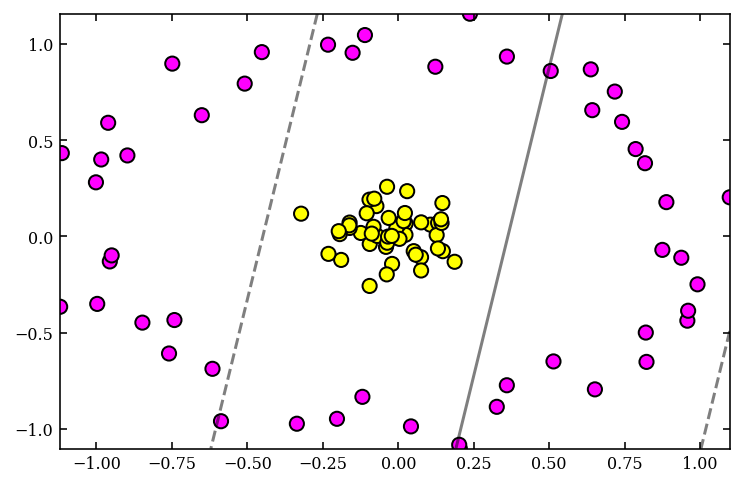

In [15]:
from sklearn.datasets import make_circles

X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, 
            cmap='spring', edgecolor='k')
plot_svc_decision_function(clf);

But we can make a transform of the data to *make* it linearly separable, for example with a simple **radial basis function** as shown below.

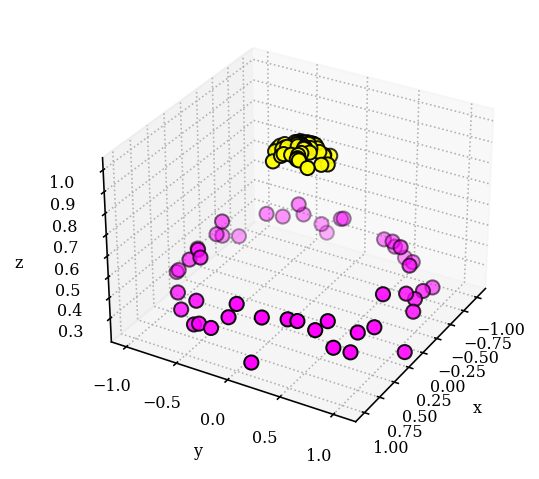

In [16]:
# Define a new feature that is related to the square of the input features.
# Points near and far from the origin will end up far away from each other.
z = np.exp(-(X[:, 0] ** 2 + X[:, 1] ** 2))

from ipywidgets import interact
#from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], z, c=y, 
                 s=50, cmap='spring', edgecolor='k')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

plot_3D()

So an appropriate decision boundary would not be linear, but instead would be radial, emanating outward from the origin. <font color='red'>Now we can trivially separate these populations using `kernel='rbf'` and `C=10`.</font>

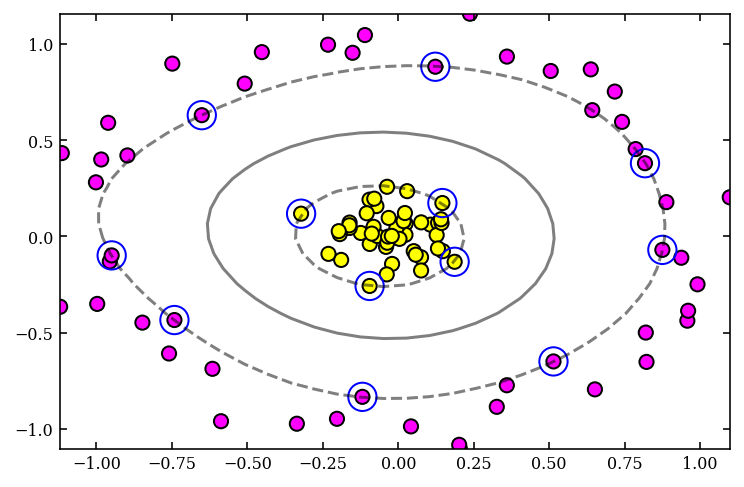

In [17]:
clf = SVC(kernel='rbf', C=10)
clf.fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, 
            cmap='spring', edgecolor='k')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], 
            clf.support_vectors_[:, 1],
            s=200, facecolors='none');

Let's look at another example of two populations generated from interleaving half-circles. This is very challenging for K-means clustering. In addition to the $C$ parameter, we'll adjust $\gamma$ which is a coefficient that scales the squared distances in the `rbf` kernel.

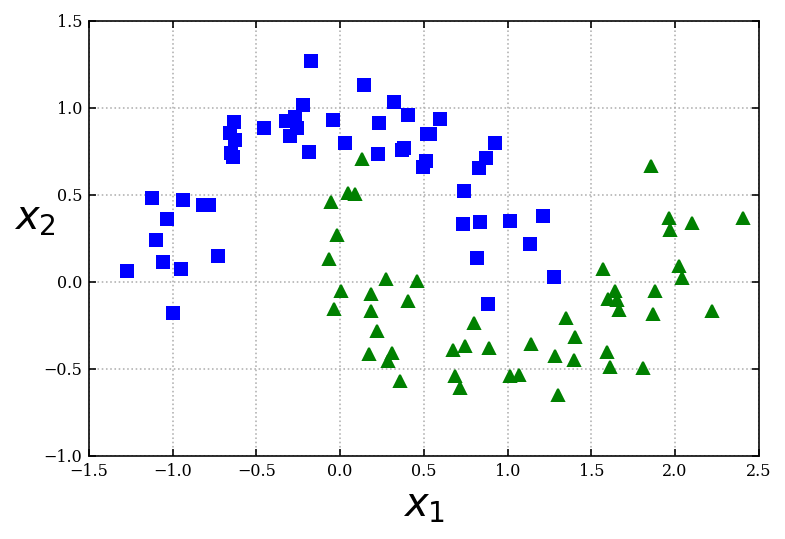

In [18]:
# Geron
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

In [19]:
# For plotting the boundaries in the Moons example
# Geron
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

<font color='red'>Try two very different values for $\gamma$ and $C$.  Of the four combinations, try to make one case where SVM is badly underfitting and one case where it is badly overfitting.</font>

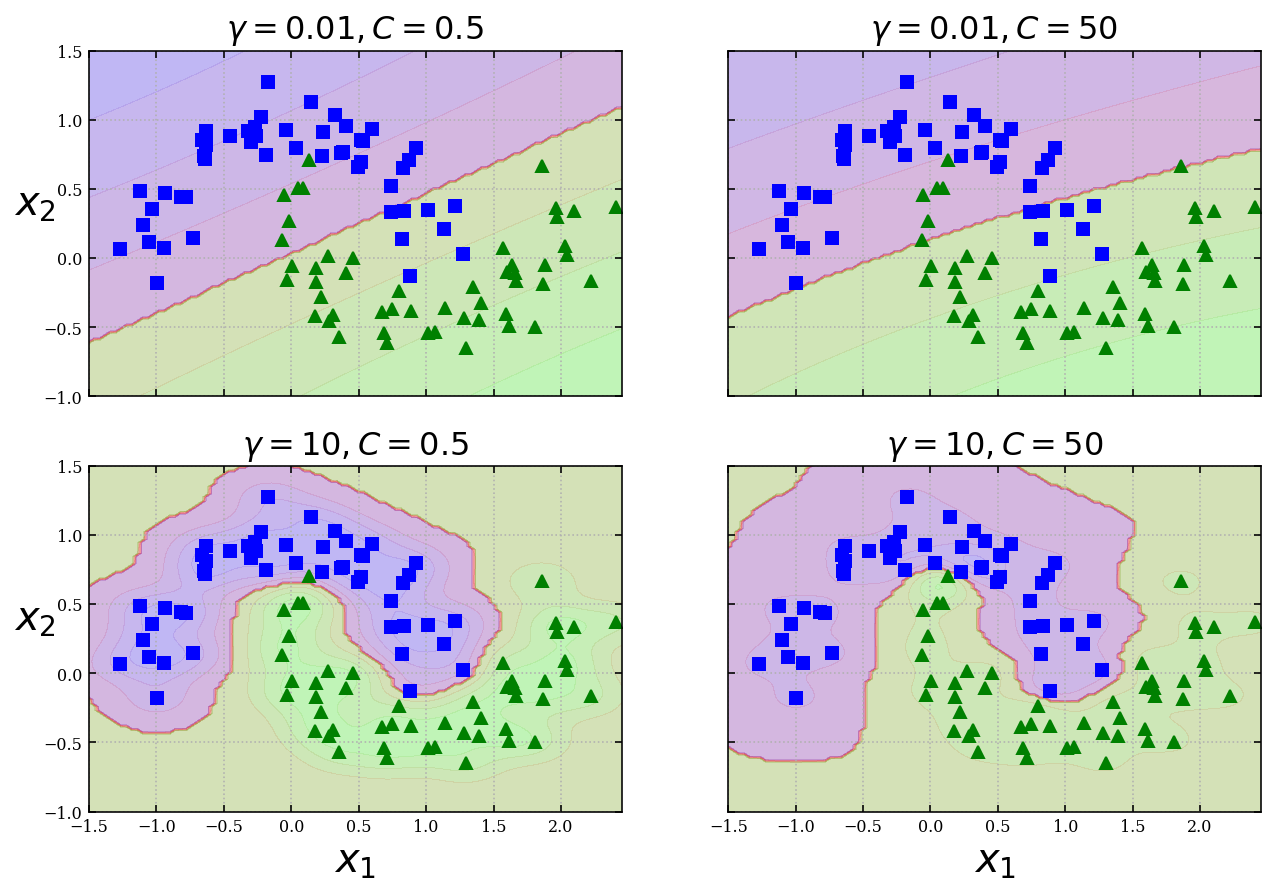

In [21]:
#Geron
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

gamma1, gamma2 = 0.01, 10
C1, C2 = 0.5, 50
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = Pipeline([
            ("scaler", StandardScaler()),
            ("svm_clf", SVC(kernel="rbf", 
                            gamma=gamma, C=C))])
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

fig, axes = plt.subplots(nrows=2, ncols=2, 
                         figsize=(10.5, 7), 
                         sharex=True, sharey=True)

for i, svm_clf in enumerate(svm_clfs):
    plt.sca(axes[i // 2, i % 2])
    plot_predictions(svm_clf, [-1.5, 2.45, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.45, -1, 1.5])
    
    gamma, C = hyperparams[i]
    plt.title(r"$\gamma = {}, C = {}$".format(gamma, C), 
              fontsize=16)
    if i in (0, 1):
        plt.xlabel("")
    if i in (1, 3):
        plt.ylabel("")
plt.show()

Note also the `Pipeline` function used in that example. It can chain together lots of operations that one would do manually in sequence, but can be easily packaged together into a compact workflow. In this circumstance it scaled the data before performing SVM classification; as mentioned SVM often requires scaling the data beforehand since it is not scale-invariant.

## Decision Trees <a class="anchor" id="four"></a>

A [**decision tree**](https://en.wikipedia.org/wiki/Decision_tree) is similar to the process of classification that you might do by hand: 

- define some criteria to separate the sample into 2 groups (not necessarily equal),
- then take those sub-groups and do it again.  
- keep going until you reach a stopping point such as not having a minimum number of objects to split again.  

In short, we have done a hierarchical application of decision boundaries.

The tree structure is as follows:
- top node contains the entire data set
- at each branch the data are subdivided into two child nodes 
- split is based on a predefined decision boundary (usually axis aligned)
- splitting repeats, recursively, until we reach a predefined stopping criteria 

Below is a simple example of a decision tree.

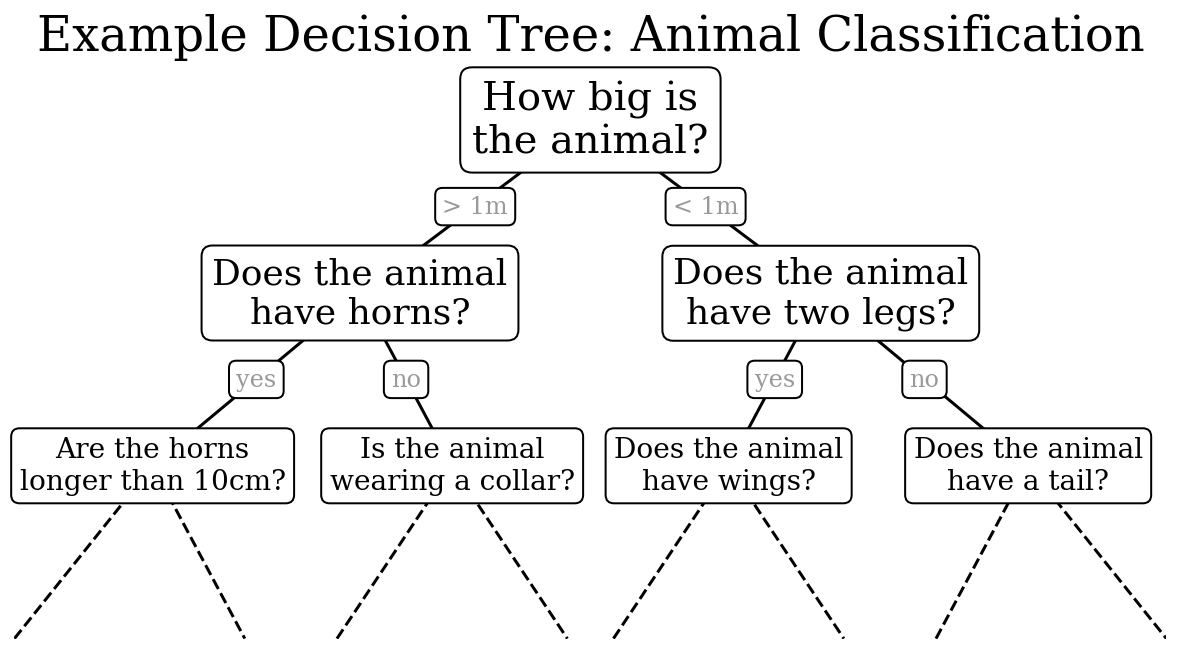

In [22]:
# Source: Jake VanderPlas, https://github.com/LocalGroupAstrostatistics2015/MachineLearning/blob/master/fig_code/figures.py
def plot_example_decision_tree():
    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_axes([0, 0, 0.8, 1], frameon=False, xticks=[], yticks=[])
    ax.set_title('Example Decision Tree: Animal Classification', size=24)

    def text(ax, x, y, t, size=20, **kwargs):
        ax.text(x, y, t,
                ha='center', va='center', size=size,
                bbox=dict(boxstyle='round', ec='k', fc='w'), **kwargs)

    text(ax, 0.5, 0.9, "How big is\nthe animal?", 20)
    text(ax, 0.3, 0.6, "Does the animal\nhave horns?", 18)
    text(ax, 0.7, 0.6, "Does the animal\nhave two legs?", 18)
    text(ax, 0.12, 0.3, "Are the horns\nlonger than 10cm?", 14)
    text(ax, 0.38, 0.3, "Is the animal\nwearing a collar?", 14)
    text(ax, 0.62, 0.3, "Does the animal\nhave wings?", 14)
    text(ax, 0.88, 0.3, "Does the animal\nhave a tail?", 14)

    text(ax, 0.4, 0.75, "> 1m", 12, alpha=0.4)
    text(ax, 0.6, 0.75, "< 1m", 12, alpha=0.4)

    text(ax, 0.21, 0.45, "yes", 12, alpha=0.4)
    text(ax, 0.34, 0.45, "no", 12, alpha=0.4)

    text(ax, 0.66, 0.45, "yes", 12, alpha=0.4)
    text(ax, 0.79, 0.45, "no", 12, alpha=0.4)

    ax.plot([0.3, 0.5, 0.7], [0.6, 0.9, 0.6], '-k')
    ax.plot([0.12, 0.3, 0.38], [0.3, 0.6, 0.3], '-k')
    ax.plot([0.62, 0.7, 0.88], [0.3, 0.6, 0.3], '-k')
    ax.plot([0.0, 0.12, 0.20], [0.0, 0.3, 0.0], '--k')
    ax.plot([0.28, 0.38, 0.48], [0.0, 0.3, 0.0], '--k')
    ax.plot([0.52, 0.62, 0.72], [0.0, 0.3, 0.0], '--k')
    ax.plot([0.8, 0.88, 1.0], [0.0, 0.3, 0.0], '--k')
    ax.axis([0, 1, 0, 1])

plot_example_decision_tree()

<!-- For our RR Lyrae stars --> 
<!-- ![Ivezic, Figure 9.12](http://www.astroml.org/_images/fig_rrlyrae_treevis_1.png) -->

The **terminal nodes ("leaf nodes")** record the fraction of points that have one classification or the other in the training set.

Application of the tree to classification is simple-- just a series of binary decisions. The fraction of points from the training set classified as one belonging to one class or the other (in the leaf node) defines the class associated with that leaf node.

The binary splitting makes this extremely efficient. The trick is to ask the *right* questions. So, decision trees are simple to interpret (just a set of questions).

Scikit-learn implements the [`DecisionTreeClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) as follows:

In [23]:
from sklearn.tree import DecisionTreeClassifier

X = np.random.random((100,2))
y = (X[:,0] + X[:,1] > 1).astype(int)

dtree = DecisionTreeClassifier(max_depth=6)
dtree.fit(X,y)

y_pred = dtree.predict(X)
print(dtree.get_depth())
print(dtree.get_n_leaves())

6
11


An example with our data set of RR Lyrae stars shows that it has moderately good completenees and contamination. But for this data set it is certainly not the optimal choice.

completeness [[0.00729927 0.33576642 0.44525547 0.53284672]
 [0.00729927 0.32116788 0.45985401 0.52554745]]
contamination [[0.66666667 0.44578313 0.28235294 0.27722772]
 [0.85714286 0.49425287 0.40566038 0.31428571]]


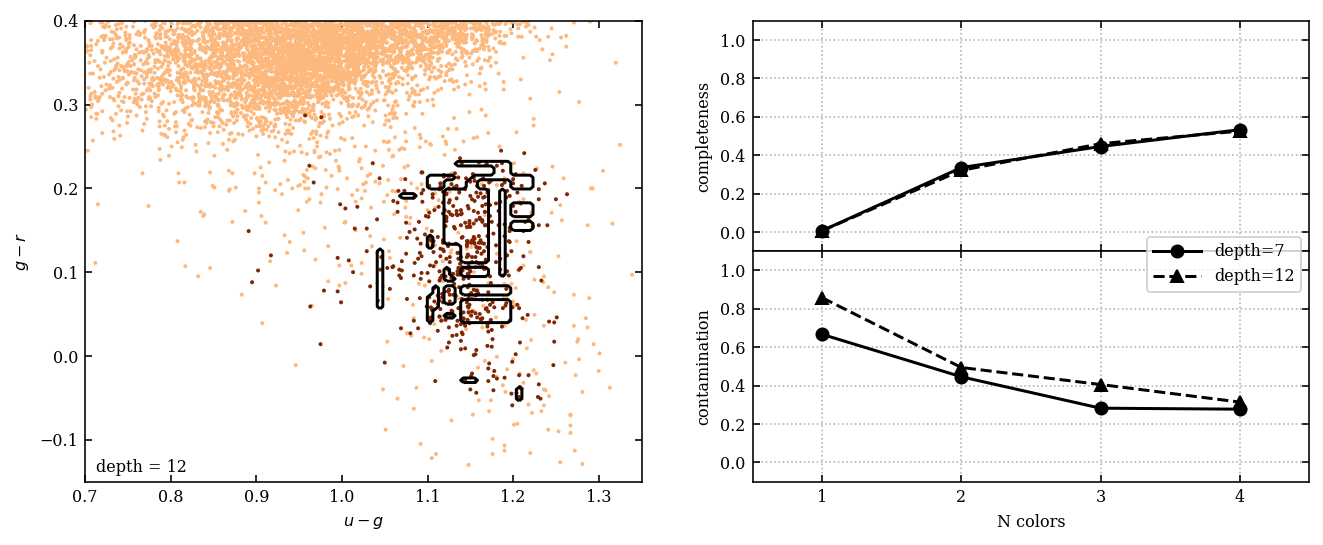

In [27]:
# Ivezic v2, Figure 9.13, edits by GTR and SRT
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
from sklearn.tree import DecisionTreeClassifier
from astroML.datasets import fetch_rrlyrae_combined
from astroML.utils import split_samples
from astroML.utils import completeness_contamination

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

#----------------------------------------------------------------------
# get data and split into training & testing sets
X, y = fetch_rrlyrae_combined()
X = X[:, [1, 0, 2, 3]]  # rearrange columns for better 1-color results
(X_train, X_test), (y_train, y_test) = split_samples(X, y, [0.75, 0.25],
                                                     random_state=0)
N_tot = len(y)
N_st = np.sum(y == 0)
N_rr = N_tot - N_st
N_train = len(y_train)
N_test = len(y_test)
N_plot = 5000 + N_rr

#----------------------------------------------------------------------
# Fit Decision tree
Ncolors = np.arange(1, X.shape[1] + 1)

classifiers = []
predictions = []
Ncolors = np.arange(1, X.shape[1] + 1)
depths = [7, 12]

for depth in depths:
    classifiers.append([])
    predictions.append([])
    for nc in Ncolors:
        clf = DecisionTreeClassifier(random_state=0, max_depth=depth,
                                     criterion='gini', min_samples_leaf=3)
        clf.fit(X_train[:, :nc], y_train)
        y_pred = clf.predict(X_test[:, :nc])

        classifiers[-1].append(clf)
        predictions[-1].append(y_pred)

completeness, contamination = completeness_contamination(predictions, y_test)

print("completeness", completeness)
print("contamination", contamination)

#------------------------------------------------------------
# compute the decision boundary

clf = classifiers[1][1]
xlim = (0.7, 1.35)
ylim = (-0.15, 0.4)

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 101),
                     np.linspace(ylim[0], ylim[1], 101))

Z = clf.predict(np.c_[yy.ravel(), xx.ravel()])
Z = Z.reshape(xx.shape)

#----------------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(10, 4))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0,
                    left=0.1, right=0.95, wspace=0.2)

# left plot: data and decision boundary
ax = fig.add_subplot(121)
im = ax.scatter(X[-N_plot:, 1], X[-N_plot:, 0], c=y[-N_plot:],
                s=4, lw=0, cmap=plt.cm.Oranges, zorder=2)
im.set_clim(-0.5, 1)

ax.contour(xx, yy, Z, [0.5], colors='k')

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel('$u-g$')
ax.set_ylabel('$g-r$')

ax.text(0.02, 0.02, "depth = %i" % depths[1],
        transform=ax.transAxes)

# plot completeness vs Ncolors
ax = fig.add_subplot(222)
ax.plot(Ncolors, completeness[0], 'o-k', ms=6, label="depth=%i" % depths[0])
ax.plot(Ncolors, completeness[1], '^--k', ms=6, label="depth=%i" % depths[1])

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.NullFormatter())

ax.set_ylabel('completeness')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

# plot contamination vs Ncolors
ax = fig.add_subplot(224)
ax.plot(Ncolors, contamination[0], 'o-k', ms=6, label="depth=%i" % depths[0])
ax.plot(Ncolors, contamination[1], '^--k', ms=6, label="depth=%i" % depths[1])
ax.legend(loc='lower right',
          bbox_to_anchor=(1.0, 0.79))

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))

ax.set_xlabel('N colors')
ax.set_ylabel('contamination')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

plt.show()

### Splitting Criteria

Now let's talk about the best ways to split the data. 

One way is to use the **information content (or "entropy")**, $E(x)$, of the data

$$ E(x) = -\sum_i p_i(x) \ln (p_i(x)),$$

where $i$ is the class and $p_i(x)$ is the probability of that class given the training data. We can define the **information gain** as the reduction in entropy due to the partitioning of the data (i.e. by partitioning the data you have reduced the disorder). For a binary split with $i=0$ representing those points below the split threshold and $i=1$ as those points above the split threshold, the information gain $IG(x)$ is

$$ IG(x|x_i) = E(x) - \sum_{i=0}^1 \frac{N_i}{N}E(x_i),$$

where $N_i$ is the number of points, $x_i$, in the $i$-th class, and $E(x_i)$ is the entropy of that class. Effectively we are assessing the information gain as the difference between the entropy of the parent node and the sum of the entropies of the child nodes. **The information gain is sometimes also referred to as the Kullback-Leibler (KL) Divergence.** 

*The typical process for finding the optimal decision boundary is to perform trial splits along each feature one at a time, within which the value of the feature to split at is also trialed. The feature that allows for the maximum information gain is the one that is split at this level.*

Another commonly used "loss function" (especially for categorical classification) is the **Gini coefficient**:

$$ G = \sum_i^k p_i(1-p_i).$$

It essentially estimates the probability of incorrect classification by choosing both a point and (separately) a class randomly from the data.

<font color='red'>Try changing the example above to use `criterion='gini'` and `min_samples_leaf=3`, see [here](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier) for all of the parameters.</font>

---
Obviously in constructing a decision treee, if your choice of stopping criteria is too loose, further splitting just ends up adding noise.  So here is an example using ***cross-validation in order to optimize the depth of the tree (and to avoid overfitting -- that is, we are doing regularization)***.  

Note that in this particular example we aren't classifying the objects into discrete categories. Rather we are classifying them into a continuous category. That is, we are performing regression. In this particular case, we are using the colors of galaxies in order to predict their redshifts (distances)-- this is known as *photometric redshift estimation*.

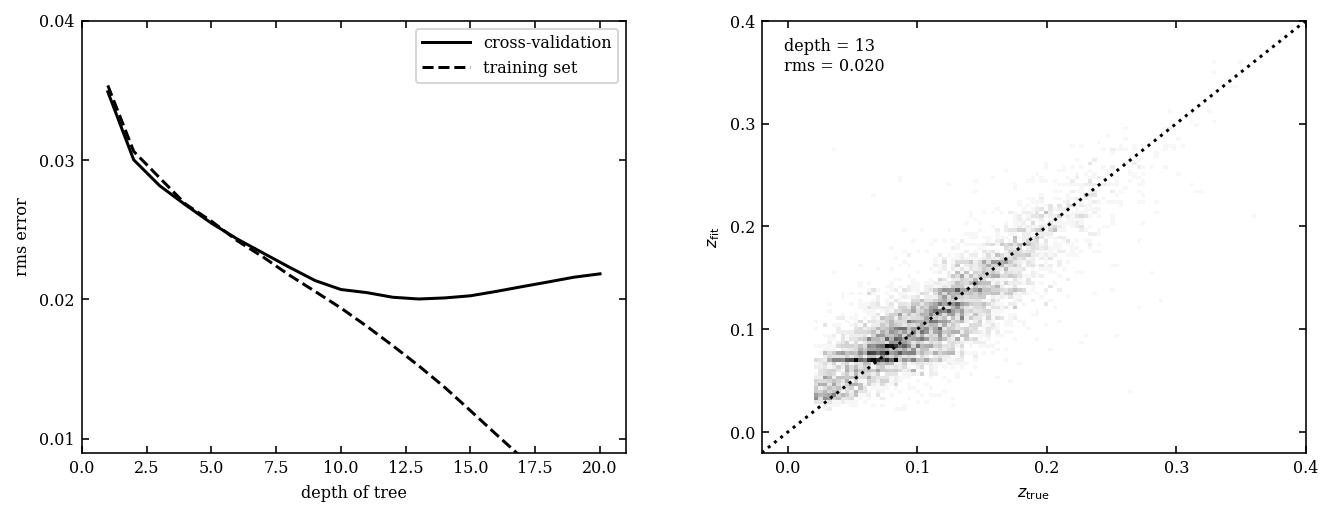

In [28]:
# Ivezic v2, Figure 9.14
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
from sklearn.tree import DecisionTreeRegressor
from astroML.datasets import fetch_sdss_specgals

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

#------------------------------------------------------------
# Fetch data and prepare it for the computation
data = fetch_sdss_specgals()

# put magnitudes in a matrix
mag = np.vstack([data['modelMag_%s' % f] for f in 'ugriz']).T
z = data['z']

# train on ~60,000 points
mag_train = mag[::10]
z_train = z[::10]

# test on ~6,000 separate points
mag_test = mag[1::100]
z_test = z[1::100]

#------------------------------------------------------------
# Compute the cross-validation scores for several tree depths
depth = np.arange(1, 21)
rms_test = np.zeros(len(depth))
rms_train = np.zeros(len(depth))
i_best = 0
z_fit_best = None

for i, d in enumerate(depth):
    clf = DecisionTreeRegressor(max_depth=d, random_state=0)
    clf.fit(mag_train, z_train)

    z_fit_train = clf.predict(mag_train)
    z_fit = clf.predict(mag_test)
    rms_train[i] = np.mean(np.sqrt((z_fit_train - z_train) ** 2))
    rms_test[i] = np.mean(np.sqrt((z_fit - z_test) ** 2))

    if rms_test[i] <= rms_test[i_best]:
        i_best = i
        z_fit_best = z_fit

best_depth = depth[i_best]

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(10, 4))
fig.subplots_adjust(wspace=0.25,
                    left=0.1, right=0.95,
                    bottom=0.15, top=0.9)

# first panel: cross-validation
ax = fig.add_subplot(121)
ax.plot(depth, rms_test, '-k', label='cross-validation')
ax.plot(depth, rms_train, '--k', label='training set')
ax.set_xlabel('depth of tree')
ax.set_ylabel('rms error')
ax.yaxis.set_major_locator(plt.MultipleLocator(0.01))
ax.set_xlim(0, 21)
ax.set_ylim(0.009,  0.04)
ax.legend(loc=1)

# second panel: best-fit results
ax = fig.add_subplot(122)
edges = np.linspace(z_test.min(), z_test.max(), 101)
H, zs_bins, zp_bins = np.histogram2d(z_test, z_fit_best, bins=edges)
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto', 
           extent=[zs_bins[0], zs_bins[-1], zs_bins[0], zs_bins[-1]],
           cmap=plt.cm.binary)
ax.plot([-0.1, 0.4], [-0.1, 0.4], ':k')
ax.text(0.04, 0.96, "depth = %i\nrms = %.3f" % (best_depth, rms_test[i_best]),
        ha='left', va='top', transform=ax.transAxes)
ax.set_xlabel(r'$z_{\rm true}$')
ax.set_ylabel(r'$z_{\rm fit}$')

ax.set_xlim(-0.02, 0.4001)
ax.set_ylim(-0.02, 0.4001)
ax.xaxis.set_major_locator(plt.MultipleLocator(0.1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))

plt.show()

But that's doing the ***Cross Validation*** by hand. Let's try it automatically using a "Moons" data set.

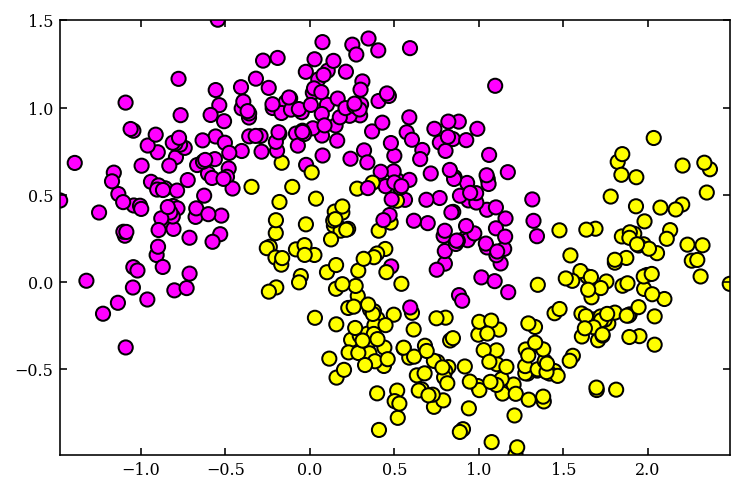

In [29]:
X, y = make_moons(n_samples=500, noise=0.20, random_state=42)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring',edgecolor='k')

<font color='red'>Do a `GridSearchCV` where you vary the `'max_depth'` between 1 and 21, using 5-fold cross validation.</font>

In [30]:
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV

clf = DecisionTreeClassifier()
drange = np.arange(1,21)  #Complete

grid = GridSearchCV(clf, param_grid={'max_depth': drange}, cv=5) #Complete
grid.fit(X, y)

best = grid.best_params_['max_depth']
print("best parameter choice:", best)

best parameter choice: 5


Now plot the decision boundary

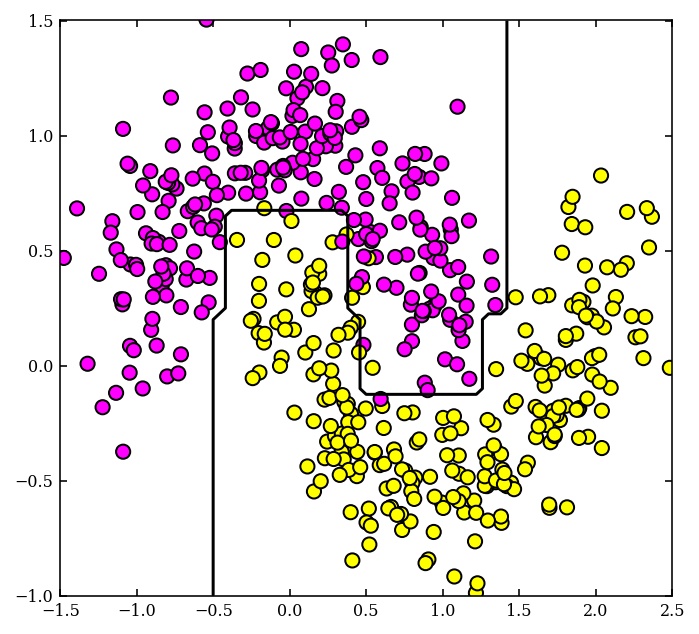

In [31]:
dt = DecisionTreeClassifier(random_state=0, max_depth=best, 
                            criterion='entropy')
dt.fit(X, y)
yprob = dt.predict_proba(X) # If we wanted probabilities rather than the discrete classes

xlim = (-1.5, 2.5)
ylim = (-1, 1.5)

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 51),
                     np.linspace(ylim[0], ylim[1], 51))
xystack = np.vstack([xx.ravel(),yy.ravel()])
Xgrid = xystack.T

Z = dt.predict(Xgrid)
Z = Z.reshape(xx.shape)

#----------------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0,
                    left=0.1, right=0.95, wspace=0.2)

# left plot: data and decision boundary
ax = fig.add_subplot(111)
im = ax.scatter(X[:, 0], X[:, 1], c=y, s=50, 
                cmap=plt.cm.spring, zorder=2, edgecolor='k')

ax.contour(xx, yy, Z, [0.5], colors='k')

Note that Decision Trees are the basis for the rest of the material today.  So it is useful to consider some of the [advantages and disadvantages](https://scikit-learn.org/stable/modules/tree.html).

For example **Decision Trees are unstable to small changes in the data (unlike SVM)**. If we rotated our moons example, we'd get a different answer. We'll see how we can harness the power of Decision Trees to create even more robust classifiers.

## Ensemble Learning <a class="anchor" id="five"></a>

You may have noticed that each of the classification methods that we have described so far has its strengths and weaknesses. You might wonder if we could gain something by some sort of averaging of weighted "voting". Such a process is what we call ***ensemble learning***.  We'll discuss two such processes: 
- [**bagging**](https://en.wikipedia.org/wiki/Bootstrap_aggregating)
- [**random forests**](https://en.wikipedia.org/wiki/Random_forest)


### Bagging

**Bagging (short for *bootstrap aggregation***) can significantly improve the performance of decision trees. In short, bagging averages the predictive results of a series of ***bootstrap*** samples of the original data.

Remember that instead of splitting the sample into training and test sets that do not overlap, bootstrap says to draw from the observed data set with replacement. So we select indices from the range $\{1,\ldots,N\}$ and this is our new sample.  Some indices will be repeated, and we do this $B$ times.

For a sample of $N$ points in a training set, bagging generates $B$ equally sized bootstrap samples from which to estimate the function $f_i(x)$. The final estimator for $\hat{y}$, defined by bagging, is then

$$\hat{y} = f(x) = \frac{1}{B} \sum_i^B f_i(x).$$

Let's compare how well a regular decision tree performs as compared to bagging applied to an ensemble of decision trees. We'll use the same moons data from above, but a bit noisier to make it harder. We'll also split into training and test sets so that both methods can be compared using a test set that neither have seen.

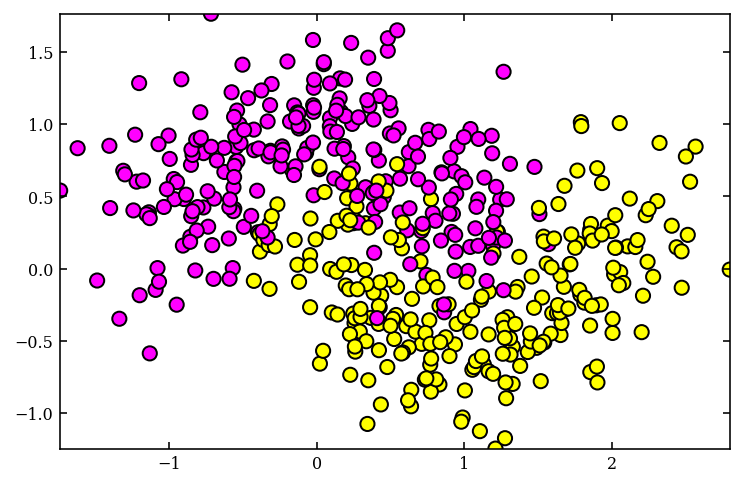

In [32]:
# Following example from Geron
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, 
            cmap='spring',edgecolor='k')

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [33]:
# Regular Decision Tree
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

y_pred_tree = tree_clf.predict(X_test)

In [36]:
# Bagged Decision Tree
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), 
    n_estimators=500, max_samples=100, 
    bootstrap=True, random_state=42, n_jobs=-1)

%timeit bag_clf.fit(X_train, y_train)

y_pred_bag = bag_clf.predict(X_test)

236 ms ± 17.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Note the `n_jobs=-1` parameter.  That says to use all the cores of your machine to do the job.  That's one of the benefits of bagging.  It can be made parallel trivially -- one bagging process has nothing to the with the others.  You just average them all together when you are done.  

<font color='red'>Try changing `n_jobs` to 1 and compare how much time it takes.  If you have a Mac, go to /Applications/Utilities/Activity Monitor, open that up and watch it spawn 4-8 Python 3.8 processes at once when you tell it to use all of the cores.</font>

OK, now let's compare the scores and we'll see that the bagging result beat the non-bagged result.  Then we'll make a plot and see why.

In [37]:
# Now compare the scores
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, y_pred_tree))
print(accuracy_score(y_test, y_pred_bag))

0.856
0.904


In [38]:
#From Geron for plotting the decision boundary
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, 
                                            -1, 1.5], 
                           alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], 
             "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], 
             "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

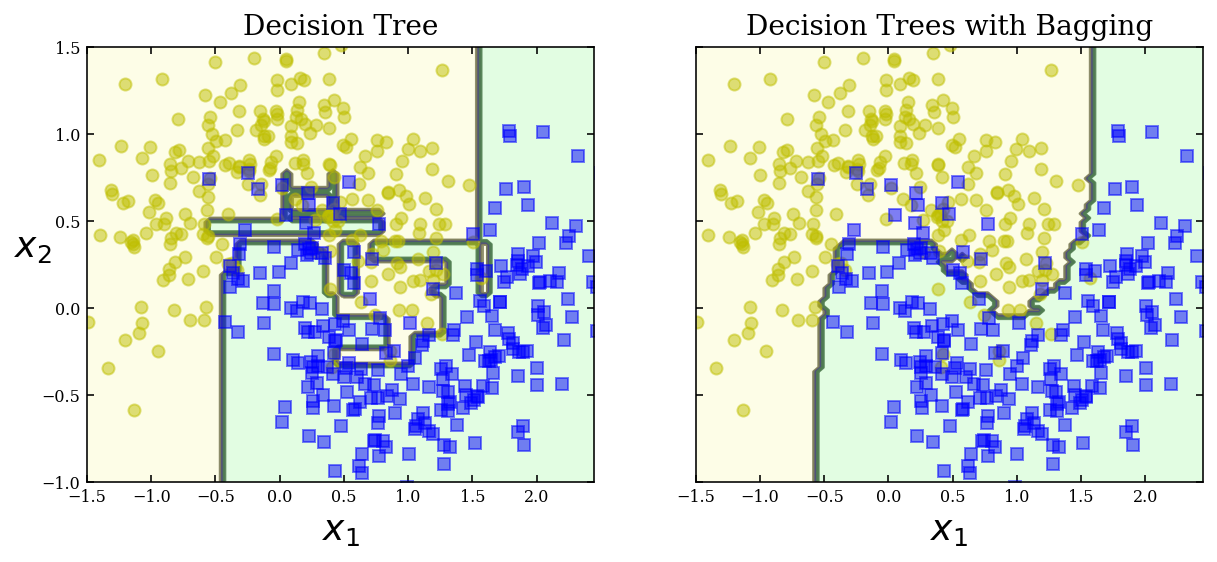

In [39]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)

plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)

plt.ylabel("")
plt.show()

### Random Forests

**[Random forests](https://www.wikiwand.com/en/Random_forest)** extend bagging by generating decision trees from the bootstrap samples.  

- In Random Forests, the ***splitting features on which to generate the tree are selected at random*** from the full set of features in the data.
- The number of features selected per split level is typically the square root of the total number of features, $\sqrt{D}$. 
- The final classification from the random forest is based on the averaging of the classifications of each of the individual decision trees. So, you can literally give it the kitchen sink (including attributes that you might not otherwise think would be useful for classification).
- Random forests help to overcome some of the limitations of decision trees.

As before, **cross-validation can be used to determine the optimal depth**.  Generally the number of trees, $n$, that are chosen is the number at which the cross-validation error plateaus.

Below we give the same example as above for photometric estimation of galaxy redshifts, where Scikit-Learn's [`RandomForestClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) call looks as follows:

In [40]:
from sklearn.ensemble import RandomForestClassifier

X = np.random.random((100,2))
y = (X[:,0] + X[:,1] > 1).astype(int)

ranfor = RandomForestClassifier(10)
ranfor.fit(X,y)

y_pred = ranfor.predict(X)

@pickle_results: computing results and saving to 'photoz_forest.pkl'


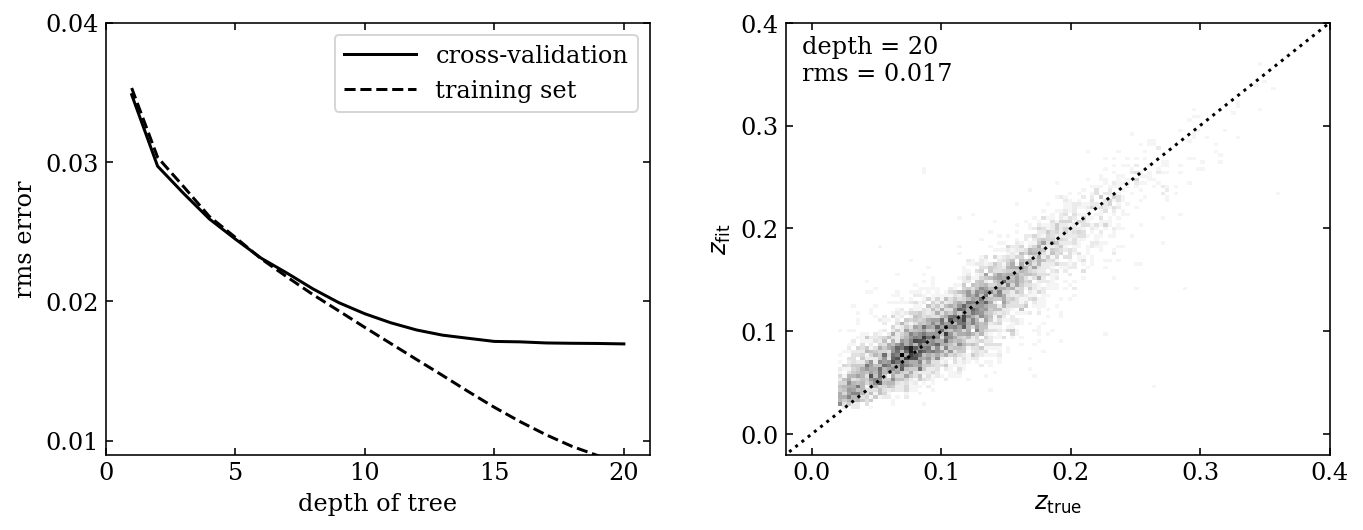

In [41]:
# Ivezic v2, Figure 9.15, edits by GTR and SRT
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
from sklearn.ensemble import RandomForestRegressor
from astroML.datasets import fetch_sdss_specgals
from astroML.utils.decorators import pickle_results

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=12, usetex=False)

#------------------------------------------------------------
# Fetch and prepare the data
data = fetch_sdss_specgals()

# put magnitudes in a matrix
mag = np.vstack([data['modelMag_%s' % f] for f in 'ugriz']).T
z = data['z']

# train on ~60,000 points
mag_train = mag[::10]
z_train = z[::10]

# test on ~6,000 distinct points
mag_test = mag[1::100]
z_test = z[1::100]


#------------------------------------------------------------
# Compute the results
#  This is a long computation, so we'll save the results to a pickle.
@pickle_results('photoz_forest.pkl')
def compute_photoz_forest(depth):
    rms_test = np.zeros(len(depth))
    rms_train = np.zeros(len(depth))
    i_best = 0
    z_fit_best = None

    for i, d in enumerate(depth):
        clf = RandomForestRegressor(n_estimators=10,
                                    max_depth=d, random_state=0)
        clf.fit(mag_train, z_train)

        z_fit_train = clf.predict(mag_train)
        z_fit = clf.predict(mag_test)
        rms_train[i] = np.mean(np.sqrt((z_fit_train - z_train) ** 2))
        rms_test[i] = np.mean(np.sqrt((z_fit - z_test) ** 2))

        if rms_test[i] <= rms_test[i_best]:
            i_best = i
            z_fit_best = z_fit

    return rms_test, rms_train, i_best, z_fit_best


depth = np.arange(1, 21)
rms_test, rms_train, i_best, z_fit_best = compute_photoz_forest(depth)
best_depth = depth[i_best]

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(10, 4))
fig.subplots_adjust(wspace=0.25,
                    left=0.1, right=0.95,
                    bottom=0.15, top=0.9)

# left panel: plot cross-validation results
ax = fig.add_subplot(121)
ax.plot(depth, rms_test, '-k', label='cross-validation')
ax.plot(depth, rms_train, '--k', label='training set')
ax.legend(loc=1)

ax.set_xlabel('depth of tree')
ax.set_ylabel('rms error')

ax.set_xlim(0, 21)
ax.set_ylim(0.009,  0.04)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.01))

# right panel: plot best fit
ax = fig.add_subplot(122)

edges = np.linspace(z_test.min(), z_test.max(), 101)
H, zs_bins, zp_bins = np.histogram2d(z_test, z_fit_best, bins=edges)
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto', 
           extent=[zs_bins[0], zs_bins[-1], zs_bins[0], zs_bins[-1]],
           cmap=plt.cm.binary)

ax.plot([-0.1, 0.4], [-0.1, 0.4], ':k')
ax.text(0.03, 0.97, "depth = %i\nrms = %.3f" % (best_depth, rms_test[i_best]),
        ha='left', va='top', transform=ax.transAxes)

ax.set_xlabel(r'$z_{\rm true}$')
ax.set_ylabel(r'$z_{\rm fit}$')

ax.set_xlim(-0.02, 0.4001)
ax.set_ylim(-0.02, 0.4001)
ax.xaxis.set_major_locator(plt.MultipleLocator(0.1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))

plt.show()

<font color='red'>How many attributes/features is the code currently using? Looking at [`RandomForestClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), print out how many features are being used and their relative importances.

Then re-run again forcing it to use 1 fewer feature than you found by adding a `max_features` parameter.</font>

In [47]:
clf = RandomForestRegressor(n_estimators=20, max_depth=20, random_state=0)
clf.fit(mag_train, z_train)

print(clf.n_features_)  # Number of Features
print(clf.feature_importances_) # Feature Importances
print(clf.score(mag_test,z_test))

5
[0.17397699 0.57440431 0.09209443 0.09819707 0.0613272 ]
0.8228373016643197


In [48]:
clf = RandomForestRegressor(n_estimators=20, max_depth=20,
                            random_state=0, max_features=4)
clf.fit(mag_train, z_train)

print(clf.n_features_)  # Number of Features
print(clf.feature_importances_) # Feature Importances
print(clf.score(mag_test,z_test))

5
[0.20088967 0.54964563 0.0887707  0.09706299 0.063631  ]
0.8233248097953506


### Boosting

**[Boosting](https://www.wikiwand.com/en/Gradient_boosting)** is an ensemble approach where many weak classifiers are combined and improved upon to make classification better. ***Boosting creates models that attempt to correct the errors of the ensemble so far.*** 

At the heart of boosting is the idea that we reweight the data based on how incorrectly the data were classified in the previous iteration.

- We run the classification multiple times and each time reweight the data based on the previous performance of the classifier. 
- At the end of this procedure we allow the classifiers to vote on the final classification. 

The most popular form of boosting is that of ***adaptive boosting***. In this case we take a weak classifier, $h(x)$, and create a strong classifier, $f(x)$, as

$$ f(x) = \sum_m^B\theta_m h_m(x),$$

where $m$ is the number of iterations and $\theta_m$ is the weight of the classifier in each iteration.  

*If we chose $\theta_m=1/B$, then we'd essentially have bagging.* For boosting the idea is to increase the weight of the misclassified data in each step.

A fundamental limitation of the boosted decision tree is the computation time for large data sets (they rely on a chain of classifiers which are each dependent on the last), whereas random forests can be easily parallelized as we saw above.

The example given below is actually Scikit-Learn's [`GradientBoostingClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) where we approximate the steepest descent criterion after each simple evaluation (more on that next time).

In [49]:
from sklearn.ensemble import GradientBoostingClassifier

X = np.random.random((100,2))
y = (X[:,0] + X[:,1] > 1).astype(int)

gradboost = GradientBoostingClassifier()
gradboost.fit(X,y)

y_pred = gradboost.predict(X)

And now try the photometric redshift estimation for galaxies again with a boosted decision tree.

@pickle_results: computing results and saving to 'photoz_boosting.pkl'


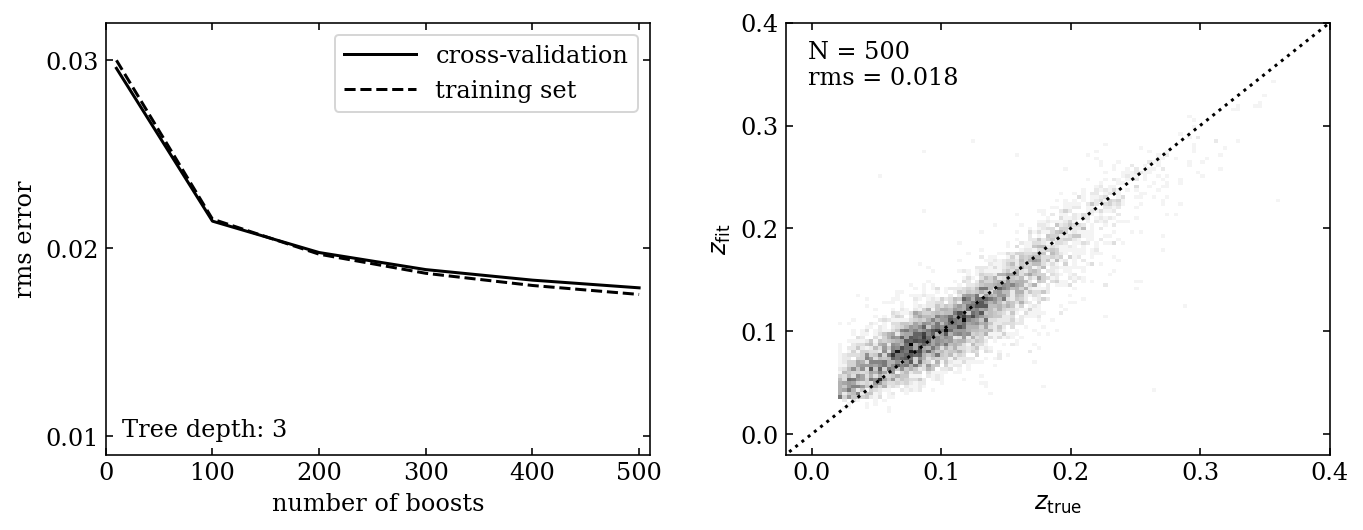

In [50]:
# Ivezic v2, Figure 9.16
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
from sklearn.ensemble import GradientBoostingRegressor
from astroML.datasets import fetch_sdss_specgals
from astroML.utils.decorators import pickle_results

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=12, usetex=False)

#------------------------------------------------------------
# Fetch and prepare the data
data = fetch_sdss_specgals()

# put magnitudes in a matrix
mag = np.vstack([data['modelMag_%s' % f] for f in 'ugriz']).T  # X
z = data['z'] # y

# train on ~60,000 points
mag_train = mag[::10] #X_train
z_train = z[::10] #y_train

# test on ~6,000 distinct points
mag_test = mag[1::100] #X_test
z_test = z[1::100] #y_test


#------------------------------------------------------------
# Compute the results
#  This is a long computation, so we'll save the results to a pickle.
@pickle_results('photoz_boosting.pkl')
def compute_photoz_forest(N_boosts):
    rms_test = np.zeros(len(N_boosts))
    rms_train = np.zeros(len(N_boosts))
    i_best = 0
    z_fit_best = None

    for i, Nb in enumerate(N_boosts):
        try:
            # older versions of scikit-learn
            clf = GradientBoostingRegressor(n_estimators=Nb, learn_rate=0.1,
                                            max_depth=3, random_state=0)
        except TypeError:
            clf = GradientBoostingRegressor(n_estimators=Nb, learning_rate=0.1,
                                            max_depth=3, random_state=0)
        clf.fit(mag_train, z_train)

        z_fit_train = clf.predict(mag_train)
        z_fit = clf.predict(mag_test)
        rms_train[i] = np.mean(np.sqrt((z_fit_train - z_train) ** 2))
        rms_test[i] = np.mean(np.sqrt((z_fit - z_test) ** 2))

        if rms_test[i] <= rms_test[i_best]:
            i_best = i
            z_fit_best = z_fit

    return rms_test, rms_train, i_best, z_fit_best

N_boosts = (10, 100, 200, 300, 400, 500)
rms_test, rms_train, i_best, z_fit_best = compute_photoz_forest(N_boosts)
best_N = N_boosts[i_best]

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(10, 4))
fig.subplots_adjust(wspace=0.25,
                    left=0.1, right=0.95,
                    bottom=0.15, top=0.9)

# left panel: plot cross-validation results
ax = fig.add_subplot(121)
ax.plot(N_boosts, rms_test, '-k', label='cross-validation')
ax.plot(N_boosts, rms_train, '--k', label='training set')
ax.legend(loc=1)

ax.set_xlabel('number of boosts')
ax.set_ylabel('rms error')
ax.set_xlim(0, 510)
ax.set_ylim(0.009,  0.032)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.01))

ax.text(0.03, 0.03, "Tree depth: 3",
        ha='left', va='bottom', transform=ax.transAxes)

# right panel: plot best fit
ax = fig.add_subplot(122)
edges = np.linspace(z_test.min(), z_test.max(), 101)
H, zs_bins, zp_bins = np.histogram2d(z_test, z_fit_best, bins=edges)
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto', 
           extent=[zs_bins[0], zs_bins[-1], zs_bins[0], zs_bins[-1]],
           cmap=plt.cm.binary)

ax.plot([-0.1, 0.4], [-0.1, 0.4], ':k')
ax.text(0.04, 0.96, "N = %i\nrms = %.3f" % (best_N, rms_test[i_best]),
        ha='left', va='top', transform=ax.transAxes)

ax.set_xlabel(r'$z_{\rm true}$')
ax.set_ylabel(r'$z_{\rm fit}$')

ax.set_xlim(-0.02, 0.4001)
ax.set_ylim(-0.02, 0.4001)
ax.xaxis.set_major_locator(plt.MultipleLocator(0.1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))

plt.show()

## Alright, brilliant, but which one should I use? <a class="anchor" id="six"></a>

A convenient cop-out: no single model can be known in advance to be the best classifier!

In general the level of accuracy increases for parametric models as:

- <b>naive Bayes</b>, 
- linear discriminant analysis (LDA),
- logistic regression, 
- linear support vector machines, 
- quadratic discriminant analysis (QDA),
- linear ensembles of linear models. 

For non-parametric models accuracy increases as:
- decision trees
- $K$-nearest-neighbor, 
- neural networks
- kernel discriminant analysis,
- <b> kernelized support vector machines</b>
- <b> random forests</b>
- boosting

See also Ivezic, Table 9.1.

Naive Bayes and its variants are by far the easiest to compute. Linear support vector machines are more expensive, though several fast algorithms exist. Random forests can be easily parallelized. 

We saw before that Scikit-learn has tools for computing ROC curves, which is implemented as follows.  

In [51]:
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

X = np.random.random((100,2))
y = (X[:,0] + X[:,1] > 1).astype(int)

gnb = GaussianNB().fit(X,y)
y_prob = gnb.predict_proba(X)

# Compute precision/recall curve
pr, re, thresh = metrics.precision_recall_curve(y, y_prob[:,0])

# Compute ROC curve
tpr, fpr, thresh = metrics.roc_curve(y, y_prob[:,0])

Let's remember what they had to say when aggregated over many different classifiers:

![Ivezic, Figure 9.17](http://www.astroml.org/_images/fig_ROC_curve_1.png)

Here's an example with a different data set. Here we are trying to distinguish quasars (in black) from stars (in grey). We'll finish off today by looking at the classification performance of many different generative and discriminative classifiers for this problem.

downloading DR7 quasar dataset from http://das.sdss.org/va/qsocat/dr7qso.dat.gz to /Users/lambwg/astroML_data
[=========================================]  12.82Mb / 12.82Mb   
GaussianNB
LinearDiscriminantAnalysis
QuadraticDiscriminantAnalysis
LogisticRegression
KNeighborsClassifier
DecisionTreeClassifier
GMMBayes


/Users/lambwg/apps/miniconda3/envs/astr8070/lib/python3.8/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


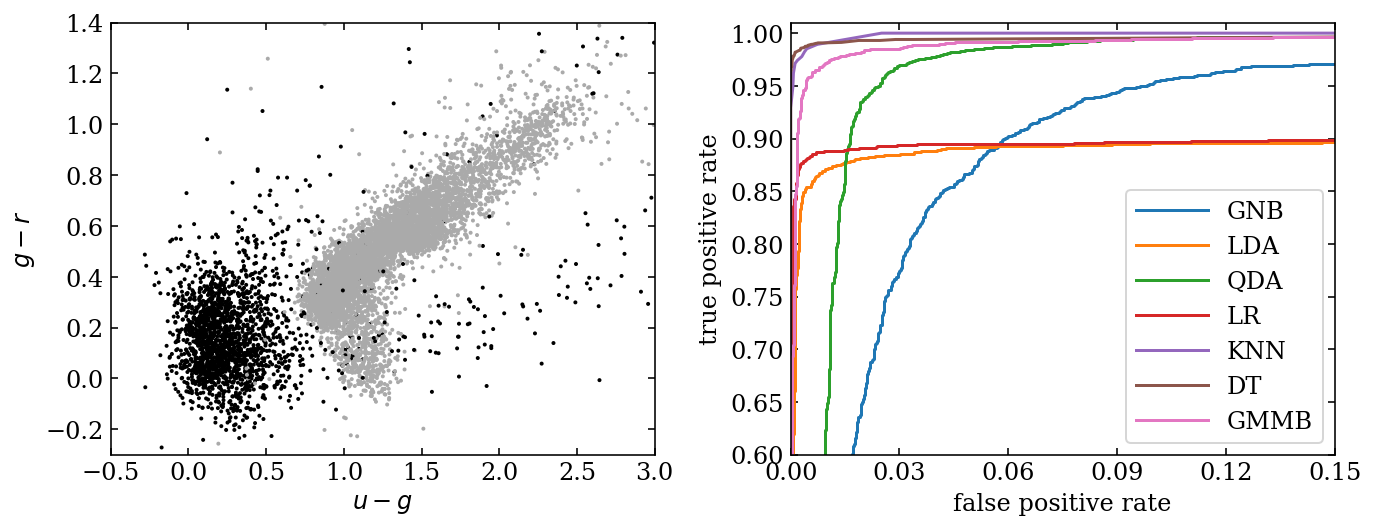

In [52]:
# Ivezic v2, Figure 9.18
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
from astroML.utils import split_samples

from sklearn.metrics import roc_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis,
                                           QuadraticDiscriminantAnalysis)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from astroML.classification import GMMBayes


#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=12, usetex=False)

#------------------------------------------------------------
# Fetch data and split into training and test samples
from astroML.datasets import fetch_dr7_quasar
from astroML.datasets import fetch_sdss_sspp

quasars = fetch_dr7_quasar()
stars = fetch_sdss_sspp()

# Truncate data for speed
quasars = quasars[::5]
stars = stars[::5]

# stack colors into matrix X
Nqso = len(quasars)
Nstars = len(stars)
X = np.empty((Nqso + Nstars, 4), dtype=float)

X[:Nqso, 0] = quasars['mag_u'] - quasars['mag_g']
X[:Nqso, 1] = quasars['mag_g'] - quasars['mag_r']
X[:Nqso, 2] = quasars['mag_r'] - quasars['mag_i']
X[:Nqso, 3] = quasars['mag_i'] - quasars['mag_z']

X[Nqso:, 0] = stars['upsf'] - stars['gpsf']
X[Nqso:, 1] = stars['gpsf'] - stars['rpsf']
X[Nqso:, 2] = stars['rpsf'] - stars['ipsf']
X[Nqso:, 3] = stars['ipsf'] - stars['zpsf']

y = np.zeros(Nqso + Nstars, dtype=int)
y[:Nqso] = 1

# split into training and test sets
(X_train, X_test), (y_train, y_test) = split_samples(X, y, [0.9, 0.1],
                                                     random_state=0)


#------------------------------------------------------------
# Compute fits for all the classifiers
def compute_results(*args):
    names = []
    probs = []

    for classifier, kwargs in args:
        print(classifier.__name__)
        model = classifier(**kwargs)
        model.fit(X, y)
        y_prob = model.predict_proba(X_test)

        names.append(classifier.__name__)
        probs.append(y_prob[:, 1])

    return names, probs

LRclass_weight = dict([(i, np.sum(y_train == i)) for i in (0, 1)])

names, probs = compute_results((GaussianNB, {}),
                               (LinearDiscriminantAnalysis, {}),
                               (QuadraticDiscriminantAnalysis, {}),
                               (LogisticRegression,
                                dict(class_weight=LRclass_weight)),
                               (KNeighborsClassifier,
                                dict(n_neighbors=10)),
                               (DecisionTreeClassifier,
                                dict(random_state=0, max_depth=12,
                                     criterion='entropy')),
                               (GMMBayes, dict(n_components=3, tol=1E-5,
                                               covariance_type='full')))

#------------------------------------------------------------
# Plot results
fig = plt.figure(figsize=(10, 4))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15, top=0.9, wspace=0.25)

# First axis shows the data
ax1 = fig.add_subplot(121)
im = ax1.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=4,
                 linewidths=0, edgecolors='none',
                 cmap=plt.cm.binary)
im.set_clim(-0.5, 1)
ax1.set_xlim(-0.5, 3.0)
ax1.set_ylim(-0.3, 1.4)
ax1.set_xlabel('$u - g$')
ax1.set_ylabel('$g - r$')

labels = dict(GaussianNB='GNB',
              LinearDiscriminantAnalysis='LDA',
              QuadraticDiscriminantAnalysis='QDA',
              KNeighborsClassifier='KNN',
              DecisionTreeClassifier='DT',
              GMMBayes='GMMB',
              LogisticRegression='LR')

# Second axis shows the ROC curves
ax2 = fig.add_subplot(122)
for name, y_prob in zip(names, probs):
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)

    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])

    ax2.plot(fpr, tpr, label=labels[name])

ax2.legend(loc=4)
ax2.set_xlabel('false positive rate')
ax2.set_ylabel('true positive rate')
ax2.set_xlim(0, 0.15)
ax2.set_ylim(0.6, 1.01)
ax2.xaxis.set_major_locator(plt.MaxNLocator(5))

plt.show()